# Imports and Global Settings

In [1]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset configuration
DATA_PATH = "/kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8"
classes = ['Cow', 'Horse', 'Pig', 'Sheep', 'Other']
IMG_SIZE = 224
PATCH_SIZE = 16
BATCH_SIZE = 16 # ViT is memory-intensive; use smaller batch size if needed

Using device: cuda


# Livestock Dataset Parser

In [2]:
class LivestockDatasetViT(Dataset):
    def __init__(self, data_dir, split='train', img_size=224):
        self.data_dir = Path(data_dir)
        self.img_dir = self.data_dir / split / 'images'
        self.label_dir = self.data_dir / split / 'labels'
        self.img_size = img_size
        self.image_files = sorted(list(self.img_dir.glob('*.jpg')) + list(self.img_dir.glob('*.png')))
        print(f"{split.upper()}: {len(self.image_files)} images loaded.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        # Read as grayscale for consistency with your CRNN experiment
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0
        image = torch.tensor(image).unsqueeze(0) # [1, 224, 224]

        label = 0
        label_path = self.label_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                content = f.readline().split()
                if content: label = int(content[0])
        
        return image, label

# Initialize Loaders
train_loader = DataLoader(LivestockDatasetViT(DATA_PATH, 'train'), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(LivestockDatasetViT(DATA_PATH, 'valid'), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(LivestockDatasetViT(DATA_PATH, 'test'), batch_size=BATCH_SIZE, shuffle=False)

TRAIN: 4867 images loaded.
VALID: 1195 images loaded.
TEST: 508 images loaded.


# ViT

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x) # [B, 768, 14, 14]
        x = x.flatten(2) # [B, 768, 196]
        return x.transpose(1, 2) # [B, 196, 768]

class LivestockViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=5, embed_dim=768, depth=6, num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 197, embed_dim)) # 196 patches + 1 cls
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dim_feedforward=2048, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))

    def forward(self, x):
        b = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        return self.mlp_head(x[:, 0])

model_vit = LivestockViT(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=0.0001) # Lower LR for Transformers

# Training

In [4]:
epochs = 25
vit_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model_vit.train()
    t_loss, t_correct, t_total = 0, 0, 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model_vit(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * imgs.size(0)
        t_correct += (out.argmax(1) == lbls).sum().item()
        t_total += lbls.size(0)

    model_vit.eval()
    v_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for imgs, lbls in valid_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model_vit(imgs)
            loss = criterion(out, lbls)
            v_loss += loss.item() * imgs.size(0)
            v_correct += (out.argmax(1) == lbls).sum().item()
            v_total += lbls.size(0)

    # Calculate metrics
    train_acc, val_acc = 100*t_correct/t_total, 100*v_correct/v_total
    vit_history['train_acc'].append(train_acc); vit_history['val_acc'].append(val_acc)
    vit_history['train_loss'].append(t_loss/t_total); vit_history['val_loss'].append(v_loss/v_total)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  [Train] Acc: {train_acc:.2f}% | Loss: {vit_history['train_loss'][-1]:.4f}")
    print(f"  [Val]   Acc: {val_acc:.2f}% | Loss: {vit_history['val_loss'][-1]:.4f}")
    print("-" * 25)

Epoch 1/25
  [Train] Acc: 52.04% | Loss: 1.1696
  [Val]   Acc: 66.44% | Loss: 0.9361
-------------------------
Epoch 2/25
  [Train] Acc: 61.89% | Loss: 0.9984
  [Val]   Acc: 66.28% | Loss: 0.8781
-------------------------
Epoch 3/25
  [Train] Acc: 69.71% | Loss: 0.7972
  [Val]   Acc: 67.78% | Loss: 0.7214
-------------------------
Epoch 4/25
  [Train] Acc: 73.95% | Loss: 0.6672
  [Val]   Acc: 65.77% | Loss: 0.8623
-------------------------
Epoch 5/25
  [Train] Acc: 75.16% | Loss: 0.6269
  [Val]   Acc: 73.97% | Loss: 0.6347
-------------------------
Epoch 6/25
  [Train] Acc: 77.13% | Loss: 0.5959
  [Val]   Acc: 69.71% | Loss: 0.7467
-------------------------
Epoch 7/25
  [Train] Acc: 78.39% | Loss: 0.5555
  [Val]   Acc: 71.55% | Loss: 0.6795
-------------------------
Epoch 8/25
  [Train] Acc: 79.72% | Loss: 0.5270
  [Val]   Acc: 74.90% | Loss: 0.6033
-------------------------
Epoch 9/25
  [Train] Acc: 80.44% | Loss: 0.5038
  [Val]   Acc: 78.08% | Loss: 0.5270
-------------------------
E

# Plotting

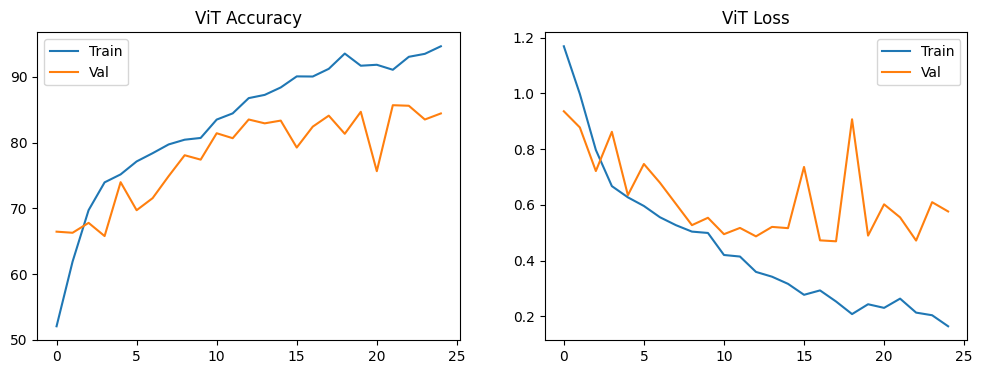

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.plot(vit_history['train_acc'], label='Train'); plt.plot(vit_history['val_acc'], label='Val')
plt.title('ViT Accuracy'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(vit_history['train_loss'], label='Train'); plt.plot(vit_history['val_loss'], label='Val')
plt.title('ViT Loss'); plt.legend()
plt.show()

# Testing

In [6]:
# Test Accuracy
model_vit.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model_vit(imgs)
        correct += (out.argmax(1) == lbls).sum().item()
        total += lbls.size(0)
print(f"Final Test Accuracy for ViT: {100*correct/total:.2f}%")

Final Test Accuracy for ViT: 83.86%
